## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [2]:
# 1
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 32.2 MB/s 
     |████████████████████████████████| 212 kB 69.8 MB/s 


In [3]:
# 2
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.2


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [4]:
# 3
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [5]:
# 4
dataset # test train validation

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [6]:
# 5
train = dataset['train']
test = dataset['test']
val = dataset['validation']

In [8]:
# 6
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels


In [9]:
# 7
tweets, labels = get_tweet(train)

In [10]:
# 8
tweets[0],labels[0]

('i didnt feel humiliated', 'sadness')

In [11]:
# 9
set(labels) 

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

## Task 4: Tokenizer

1. Tokenizing the tweets

In [12]:
# 10
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
# 11

tokenizer = Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [14]:
# 12
tokenizer.texts_to_sequences([tweets[0]]),tweets[0]

([[2, 139, 3, 679]], 'i didnt feel humiliated')

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

In [15]:
# 13
len(tweets[0]) # inditical

23

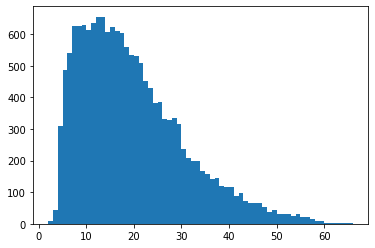

In [16]:
# 14
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [17]:
# 15
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
# 16
len(tweets)

16000

In [19]:
# 17
sequences= tokenizer.texts_to_sequences(tweets)
len(sequences)

16000

In [20]:
# 18
sequences[0]

[2, 139, 3, 679]

In [21]:
# 19
def get_sequences(tokenizer,tweets):
  sequences= tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post',padding = 'post',maxlen=maxlen) # remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences.
  #pad either before or after each sequence.

  return padded

In [22]:
# 20
padded_train_seq = get_sequences(tokenizer,tweets)

In [23]:
# 21
padded_train_seq.shape

(16000, 50)

In [24]:
# 22
padded_train_seq[0],tweets[0],tokenizer.texts_to_sequences([tweets[0]])

(array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
 'i didnt feel humiliated',
 [[2, 139, 3, 679]])

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [25]:
# 23
classes = set (labels)
print(classes)

{'fear', 'joy', 'love', 'sadness', 'anger', 'surprise'}


<function matplotlib.pyplot.show(*args, **kw)>

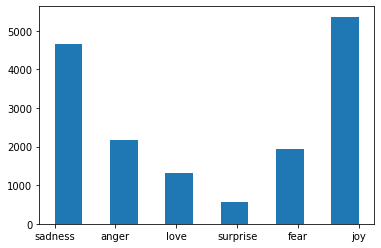

In [26]:
# 24
plt.hist(labels,bins = 11)
plt.show

In [27]:
# 25
class_to_index = dict((key,index) for index, key in enumerate(classes))
index_to_class = dict((index,key) for index, key in enumerate(classes))

In [28]:
# 26
class_to_index ,index_to_class # dict for lables

({'fear': 0, 'joy': 1, 'love': 2, 'sadness': 3, 'anger': 4, 'surprise': 5},
 {0: 'fear', 1: 'joy', 2: 'love', 3: 'sadness', 4: 'anger', 5: 'surprise'})

In [29]:
# 27
labels_to_ids = lambda labels:np.array([class_to_index.get(x) for x in labels])

In [30]:
# 28
train_labels = labels_to_ids(labels)

In [31]:
# 29
train_labels[0],labels[0]

(3, 'sadness')

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [32]:
# 30
a = np.random.randint(1000, size=(32, 10))
a[31] 

array([699, 596, 146, 281, 178, 874, 801, 230, 972, 200])

In [33]:
# 31
model = tf.keras.models.Sequential(
    [
     tf.keras.layers.Embedding(10000,16,input_length=maxlen),# 10000 for vocbs number ;for per word is 16 dims
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True),name='lstm_1'), # 20 *2  return all cells not the the last output. in the output sequence, or the full sequence
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20),name='lstm_2'),
     
    # # tf.keras.Input(shape=(50,)),# train for Dense withot embedding
    #  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=20,return_sequences=True)),
    #  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20)),
     tf.keras.layers.Dense(units=12,activation='relu',name='last_second_layer'),
     tf.keras.layers.Dense(units=6,activation='softmax',name='output_layer') # for 6 class
    ],
    name = 'my_model'
)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [34]:
# 32
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 lstm_1 (Bidirectional)      (None, 50, 40)            5920      
                                                                 
 lstm_2 (Bidirectional)      (None, 40)                9760      
                                                                 
 last_second_layer (Dense)   (None, 12)                492       
                                                                 
 output_layer (Dense)        (None, 6)                 78        
                                                                 
Total params: 176,250
Trainable params: 176,250
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [35]:
# 33
# extract the val and lables
val_tweets,val_labels = get_tweet(val)

In [36]:
# 34
val[0]

{'label': 'sadness',
 'text': 'im feeling quite sad and sorry for myself but ill snap out of it soon'}

In [37]:
# 35
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 'sadness')

In [38]:
# for the model input
# 36
val_seq =get_sequences(tokenizer, val_tweets)
val_labels = labels_to_ids(val_labels)

In [39]:
# 37
val_seq[0],val_labels[0]

(array([ 17,   8, 157, 260,   4, 343,  16,  51,  19, 212,   1,  50,  10,
         13, 533,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
 3)

In [40]:
# 38
history= model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    batch_size= 128,
    callbacks=[
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]
)

Epoch 1/20
125/125 [==============================] - 14s 38ms/step - loss: 1.6092 - accuracy: 0.3449 - val_loss: 1.5193 - val_accuracy: 0.4370
Epoch 2/20
125/125 [==============================] - 2s 13ms/step - loss: 1.1371 - accuracy: 0.5804 - val_loss: 1.0286 - val_accuracy: 0.6040
Epoch 3/20
125/125 [==============================] - 2s 13ms/step - loss: 0.8857 - accuracy: 0.6702 - val_loss: 1.0107 - val_accuracy: 0.6125
Epoch 4/20
125/125 [==============================] - 2s 13ms/step - loss: 0.7585 - accuracy: 0.7171 - val_loss: 0.8583 - val_accuracy: 0.6970
Epoch 5/20
125/125 [==============================] - 2s 13ms/step - loss: 0.6720 - accuracy: 0.7400 - val_loss: 0.8396 - val_accuracy: 0.7050
Epoch 6/20
125/125 [==============================] - 2s 14ms/step - loss: 0.6113 - accuracy: 0.7458 - val_loss: 0.7646 - val_accuracy: 0.7030
Epoch 7/20
125/125 [==============================] - 2s 17ms/step - loss: 0.4515 - accuracy: 0.8326 - val_loss: 0.7258 - val_accuracy: 0.745

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

In [41]:
# 39
history.history

{'loss': [1.609229564666748,
  1.1371186971664429,
  0.8857062458992004,
  0.7585046291351318,
  0.6720385551452637,
  0.6112901568412781,
  0.45145806670188904,
  0.34871596097946167,
  0.2739536762237549,
  0.23600426316261292,
  0.2020845115184784,
  0.1795903891324997,
  0.1602548062801361,
  0.13942497968673706,
  0.13399694859981537,
  0.11650793254375458],
 'accuracy': [0.3448750078678131,
  0.5803750157356262,
  0.6701874732971191,
  0.7171249985694885,
  0.7400000095367432,
  0.7457500100135803,
  0.8326249718666077,
  0.8763750195503235,
  0.9097499847412109,
  0.9279375076293945,
  0.9393125176429749,
  0.9466875195503235,
  0.9538750052452087,
  0.9611250162124634,
  0.9631875157356262,
  0.9684374928474426],
 'val_loss': [1.519309163093567,
  1.0286487340927124,
  1.0107157230377197,
  0.8582742214202881,
  0.8396374583244324,
  0.7646002769470215,
  0.7258284687995911,
  0.6439923048019409,
  0.633773148059845,
  0.6508872509002686,
  0.6883581280708313,
  0.7481064796447

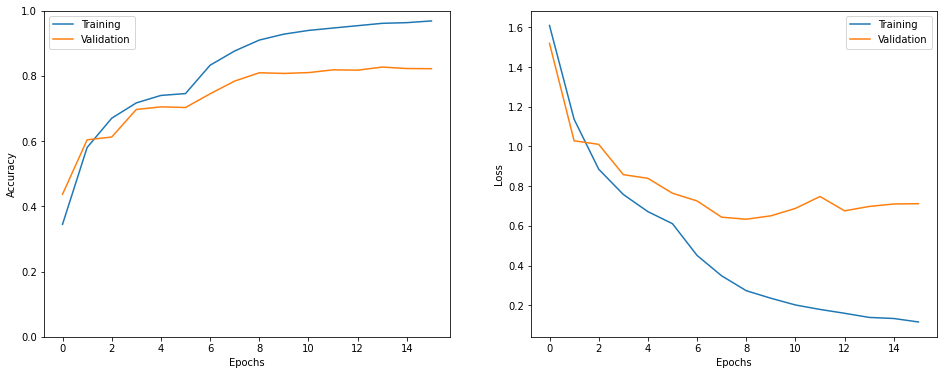

In [42]:
# 40
show_history(history)

In [43]:
# 41
test_tweets,test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer,test_tweets)
test_labels = labels_to_ids(test_labels)

In [44]:
# 42
# evaluate for test
_ = model.evaluate(test_seq,test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.7539 - accuracy: 0.8125


In [45]:
# 43
i= random.randint(0,len(test_labels) - 1)
print('sentence:',test_tweets[i])
print('Eotion:',index_to_class[test_labels[i]])


sentence: i feel like i am joining the masses which goes against my rebellion of the popular mentality ha i m so goth but i take peace in knowing that i am not making the same resolutions as everyone else
Eotion: joy


In [46]:
# 44
pred = model.predict(np.expand_dims(test_seq[i],axis=0))# (1, 50) shape for input
pred_class = index_to_class[np.argmax(pred)] # back to class
print('Predicted Emotion:',pred_class) 

1/1 [==============================] - 1s 1s/step
Predicted Emotion: joy


In [47]:
# 45
preds = model.predict(test_seq)
preds_class = np.argmax(preds,axis=1)

63/63 [==============================] - 0s 6ms/step


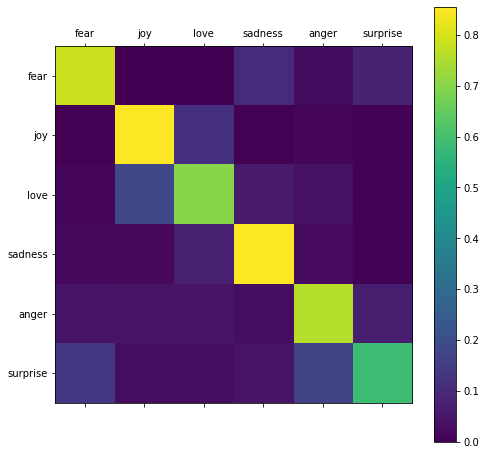

In [48]:
# 46
# confusion matricx
show_confusion_matrix(test_labels,preds_class,list(classes))